In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import matplotlib.image as mpimg
from typing import Tuple
import os
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import dump, load
from collections import namedtuple
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import seaborn as sns

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import Callback

from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer

In [2]:
# GPU 할당량 조정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*3.5)]) # 1660super 총 vram 6gb 중 5.5gb 할당
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
class InnerConv1DBlock(tf.keras.layers.Layer):
    def __init__(self, filters: int, h: int, kernel_size: int, neg_slope: float = .01, dropout: float = .5,
                 name: str = ''):
        super(InnerConv1DBlock, self).__init__(name=name)
        self.conv1d = tf.keras.layers.Conv1D(h * filters, kernel_size, padding='same')
        self.leakyrelu = tf.keras.layers.LeakyReLU(neg_slope)

        self.dropout = tf.keras.layers.Dropout(dropout)

        self.conv1d2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.tanh = tf.keras.activations.tanh

    def call(self, input_tensor):
        x = self.conv1d(input_tensor)
        x = self.leakyrelu(x)

        x = self.dropout(x)

        x = self.conv1d2(x)
        x = self.tanh(x)
        return x


class Exp(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Exp, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.exp(inputs)


class Split(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Split, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs[:, ::2], inputs[:, 1::2]

class Attention(tf.keras.layers.Layer):

    def __init__(self, units=64, shape = (1,1,1), **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.dense1 = tf.keras.layers.Dense(units=shape[2], use_bias = False, name='attention_score_vec')
        self.lambda_ = tf.keras.layers.Lambda(lambda x : x[:,-1,:], output_shape=(shape[2],),name='last_hidden_state')
        # x.mean(axis = 1) - image attention, 
        self.dot1 = tf.keras.layers.Dot(axes=[1, 2], name='attention_score')
        self.activation = tf.keras.layers.Activation('softmax', name='attention_weight')
        self.dot2 =  tf.keras.layers.Dot(axes=[1, 1], name='context_vector')
        self.concat =  tf.keras.layers.Concatenate(name='attention_output')
        self.dense2 = tf.keras.layers.Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        self.attention_weight = []

    def call(self, inputs):

        hidden_states = inputs

        score_first_part = self.dense1(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = self.lambda_(hidden_states)
        score =self.dot1([h_t, score_first_part]) # batch, time_stamps
        self.attention_weight = score # batch , time_stamps
        attention_weights = self.activation(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.dot2([hidden_states, attention_weights]) # batch_size, n_features
        pre_activation = self.concat([context_vector, h_t])
        attention_vector =self.dense2(pre_activation)
        return attention_vector, context_vector

    def get_config(self):
        return {'Attention_weights': self.attention_weight}



class SciBlock(tf.keras.layers.Layer):
    def __init__(self, kernel_size: int, h: int):
        super(SciBlock, self).__init__()
        self.kernel_size = kernel_size
        self.h = h

        self.split = Split()
        self.exp = Exp()

    def build(self, input_shape):
        _, _, filters = input_shape

        self.psi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='psi')
        self.phi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='phi')
        self.eta = InnerConv1DBlock(filters, self.h, self.kernel_size, name='eta')
        self.rho = InnerConv1DBlock(filters, self.h, self.kernel_size, name='rho')

    def call(self, input_tensor):
        F_odd, F_even = self.split(input_tensor)

        F_s_odd = F_odd * self.exp(self.phi(F_even))
        F_s_even = F_even * self.exp(self.psi(F_s_odd))

        F_prime_odd = F_s_odd + self.rho(F_s_even)
        F_prime_even = F_s_even - self.eta(F_s_odd)

        return F_prime_odd, F_prime_even


class Interleave(tf.keras.layers.Layer):
    def __init__(self):
        super(Interleave, self).__init__()

    def interleave(self, slices):
        if not slices:
            return slices
        elif len(slices) == 1:
            return slices[0]

        mid = len(slices) // 2

        even = self.interleave(slices[:mid])
        odd = self.interleave(slices[mid:])

        shape = tf.shape(even)
        return tf.reshape(tf.stack([even, odd], axis=3), (shape[0], shape[1]*2, shape[2]))

    def call(self, inputs):
        return self.interleave(inputs)


class SciNet(tf.keras.layers.Layer):
    def __init__(self, output_length: int, level: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), shape : Tuple[float, float, float] = (0, 0, 0)):
        super(SciNet, self).__init__()
        self.level = level
        self.h = h
        self.kernel_size = kernel_size
        self.max_nodes = 2 ** (level + 1) - 1

        self.sciblocks = [SciBlock(kernel_size, h) for _ in range(self.max_nodes)]
        self.interleave = Interleave()
        self.Attention = Attention(shape=shape)
        self.flatten = tf.keras.layers.Flatten()
        # self.dense1 = tf.keras.layers.Dense(100, kernel_regularizer=L1L2(0.001, 0.01))
        self.dense = tf.keras.layers.Dense(output_length, kernel_regularizer=L1L2(0.001, 0.01))
        self.regularizer = tf.keras.layers.ActivityRegularization(l1=regularizer[0], l2=regularizer[1])

    def build(self, input_shape):
        assert input_shape[1] / 2 ** 1 % 1 == 0  # inputs must be evenly divided at the lowest level of the tree
        [layer.build(input_shape) for layer in self.sciblocks]
    @tf.function
    def call(self, input_tensor):
        # cascade input down a binary tree of sci-blocks
        inputs = [input_tensor]
        for i in range(self.level):
            i_end = 2 ** (i + 1) - 1
            i_start = i_end - 2 ** i
            outputs = [out for j, tensor in zip(range(i_start, i_end), inputs) for out in self.sciblocks[j](tensor)]
            inputs = outputs

        x = self.interleave(outputs)
        x += input_tensor

        x, attention_weights = self.Attention(x)
        # x = self.dense1(x)
        x = self.dense(x)

        # x = self.regularizer(x)
        return x, attention_weights

    def get_config(self):
        return {'Attention_layer': self.Attention}

In [4]:
class VisualizeAttentionMap(Callback):
    
    def __init__(self, model, x, weights):

        super().__init__()
        self.model = model
        self.x = x
        self.weights = weights
        self.activation = tf.keras.layers.Activation('softmax')

    def on_epoch_begin(self, epoch, logs=None):
        #input_ = self.model._feed_inputs[0]
        #output = self.activation(input)
        #test = tf.keras.models.Model(inputs= input, outputs = output)
        #x = test(self.x)
        #attention_map = tf.matmul(self.weights,x).numpy()
        #test.layers[1].set_weights(weights = self.weights)
        #test.layers[1]  = test.layers[1].output.from_tensor(tensor =tf.nn.softmax(self.weights))
        #attention_map = test(self.x).numpy()
        attention_map = tf.nn.softmax(tf.math.divide(self.weights,3), axis = 1) # softmax smoothing
        
        #x = self.x[..., 0]
        if epoch % 10 == 0 :
            plt.figure(figsize= (10,5))
            maps = [attention_map]
            maps_names = ['attention layer']
            plt.imshow(maps[0], cmap='jet')
            plt.show()

        return attention_map


def softmax_with_temperature(z, T) : 
    z = np.array(z)
    z = z / T 
    max_z = np.max(z, axi) 
    exp_z = np.exp(z-max_z) 
    sum_exp_z = np.sum(exp_z)
    y = exp_z / sum_exp_z
    return y


def create_argmax_mask(x):
    mask = np.zeros_like(x)
    for i, m in enumerate(x.argmax(axis=1)):
        mask[i, m] = 1
    return mask

In [5]:
def split_sequence(sequence, look_back_window: int, forecast_horizon: int, stride: int = 1):
    X, y = [], []
    for i in range(0, len(sequence), stride):
        # find the end x and y
        end_ix = i + look_back_window
        end_iy = end_ix + forecast_horizon

        # check if there is enough elements to fill this x, y pair
        if end_iy > len(sequence):
            break

        X.append(sequence[i:end_ix])
        y.append(sequence[end_iy - 1 if forecast_horizon == 1 else end_ix:end_iy])
    return np.asarray(X), np.asarray(y)


class StocksImputer(TransformerMixin):
    def __init__(self, method: str = 'linear', fail_save: TransformerMixin = SimpleImputer()):
        self.method = method
        self.fail_save = fail_save

    def fit(self, data):
        if self.fail_save:
            self.fail_save.fit(data)
        return self

    def transform(self, data):
        # Interpolate missing values in columns
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)
        data = data.interpolate(method=self.method, limit_direction='both')
        # spline or time may be better?

        if self.fail_save:
            data = self.fail_save.transform(data)

        return data


def difference(dataset, interval=1, relative=False, min_price=1e-04):
    delta = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        if relative:
            prev_price = dataset[i - interval]
            prev_price[prev_price == 0] = min_price
            value /= prev_price
        delta.append(value)
    return np.asarray(delta)


class ARIMAPreprocessor(TransformerMixin):
    def __init__(self, y_col: str, look_back_window: int, forecast_horizon: int, stride: int, diff_order: int,
                 relative_diff: bool = True, splitXy: bool = True, scaling: str = 'minmax'):
        super().__init__()
        assert look_back_window > 0 and forecast_horizon > 0 and stride > 0

        self.y_col = y_col
        self.y_idx = None
        self.look_back_window = look_back_window
        self.forecast_horizon = forecast_horizon
        self.stride = stride
        self.diff_order = diff_order
        self.relative_diff = relative_diff
        self.splitXy = splitXy
        self.interpolation_imputer = StocksImputer(method='linear')

        if scaling == 'minmax':
            self.scaler = MinMaxScaler()
            self.y_scaler = MinMaxScaler()
        elif scaling == 'standard':
            self.scaler = StandardScaler()
            self.y_scaler = StandardScaler()
        elif scaling == 'robust':
            self.scaler = RobustScaler()
            self.y_scaler = RobustScaler()

    def fit_transform(self, data, **fit_params):
        self.y_idx = list(data.columns).index(self.y_col)

        # Fill missing values via interpolation
        data = self.interpolation_imputer.fit_transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        self.y_scaler.fit(data[:, self.y_idx].reshape(-1, 1))  # for reversing scaling post prediction
        data = self.scaler.fit_transform(data)

        if not self.splitXy:
            return data

        # Extract X, y from time series
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y, self.scaler

    def transform(self, data):
        # Fill missing values via interpolation
        data = self.interpolation_imputer.transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        data = self.scaler.transform(data)

        if not self.splitXy:
            return data

        # Extract X, y
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y

In [6]:
# Make model
def make_model(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def make_model_2(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    #tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
    #             metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [7]:
# Hyper Parametres
y_col = '일별배출량합계'
index_col = '일자'
cluster_num = 3

data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')
data = data[data['읍면동'] != '알수없음']

EPOCHS = 300

degree_of_differencing = 0
look_back_window, forecast_horizon = 60*2 * (data.읍면동.nunique()), 62 * (data.읍면동.nunique()) #전에 몇개의 데이터 참조, 후에 몇개 예측
batch_size = 16
learning_rate = 9e-5
h, kernel_size, level = 4, 5, 3
#stride = look_back_window + forecast_horizon  # unsure if any value lower than this would cause data leak

data = data.sort_values(by = ['일자','읍면동'])
data['일자'] = pd.to_datetime(data['일자'])
data = data.set_index(keys = '일자')
data = data.loc["2019-11-07":, :]

#train_data = data[:int(0.6 * len(data))]
#val_data = data[int(0.6 * len(data)):int(0.8 * len(data))]
#test_data = data[int(0.8 * len(data)):]

In [8]:
train = data[:-look_back_window]
final_test_data = data[-look_back_window:]

In [9]:
data.drop(['읍면동'], axis=1, inplace=True)

In [10]:
train.drop(['읍면동'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
train_data = train[:int(0.8 * (len(train) - (look_back_window + forecast_horizon)))]   #train_data = train[:int(0.6 * len(data))]
val_data = train[int(0.8 * (len(train) - (look_back_window + forecast_horizon))):-look_back_window + forecast_horizon]
test_data = train[-(look_back_window + forecast_horizon):]

In [12]:
train_data.shape, val_data.shape, test_data.shape

((1200, 42), (920, 42), (910, 42))

In [13]:
look_back_window + forecast_horizon

910

In [14]:
# Train model
preprocessor = ARIMAPreprocessor(y_col, look_back_window, forecast_horizon, 1, degree_of_differencing,
                                  relative_diff=True, scaling='standard')
X_train, y_train, scaler = preprocessor.fit_transform(train_data)
X_val, y_val = preprocessor.transform(val_data)
print(f'Input shape: X{X_train.shape}, y{y_train.shape}')

Input shape: X(291, 600, 42), y(291, 310)


In [15]:
model = make_model_2(batch_size, X_train.shape[1], X_train.shape[2])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 42)]         0         
_________________________________________________________________
sci_net (SciNet)             ((None, 310), (None, 42)) 2008850   
Total params: 2,008,850
Trainable params: 2,008,850
Non-trainable params: 0
_________________________________________________________________


In [17]:
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean()

val_loss = tf.keras.metrics.Mean()

train_loss_list = []
val_loss_list = []


def train_function(train_X, train_y):
    with tf.GradientTape() as tape:
     
        predictions, attention_weights = model(train_X)
       
        loss = loss_function(train_y, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    mse = tf.keras.metrics.mse(train_y, predictions)
    mae = tf.keras.metrics.mae(train_y, predictions)

    return loss, mse, mae, attention_weights

def test_function(val_X, val_y):

    predictions, _ = model(val_X)
 
    loss = loss_function(val_y, predictions)

    val_loss(loss)
    mse = tf.keras.metrics.mse(val_y, predictions)
    mae = tf.keras.metrics.mae(val_y, predictions)

    return loss, mse, mae

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [19]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

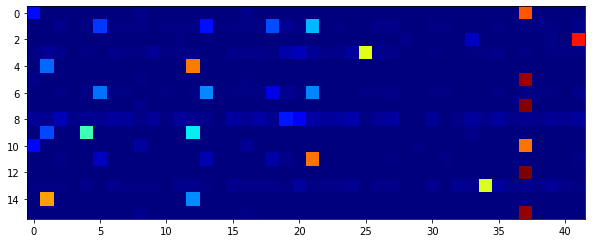

epochs: 1/300, train loss : 1.11315 train mse: 1.11315 train mae: 0.77971  validation loss: 0.88075 validation mse : 0.88075 validation mae: 0.73045
epochs: 2/300, train loss : 1.06009 train mse: 1.00702 train mae: 0.73685  validation loss: 0.84765 validation mse : 0.81456 validation mae: 0.69682
epochs: 3/300, train loss : 1.01569 train mse: 0.92689 train mae: 0.70010  validation loss: 0.81687 validation mse : 0.75530 validation mae: 0.67142
epochs: 4/300, train loss : 0.97631 train mse: 0.85817 train mae: 0.66974  validation loss: 0.79630 validation mse : 0.73458 validation mae: 0.66351
epochs: 5/300, train loss : 0.94112 train mse: 0.80037 train mae: 0.64191  validation loss: 0.77514 validation mse : 0.69052 validation mae: 0.64305
epochs: 6/300, train loss : 0.90898 train mse: 0.74827 train mae: 0.61412  validation loss: 0.75446 validation mse : 0.65107 validation mae: 0.62429
epochs: 7/300, train loss : 0.87911 train mse: 0.69992 train mae: 0.58687  validation loss: 0.73449 valida

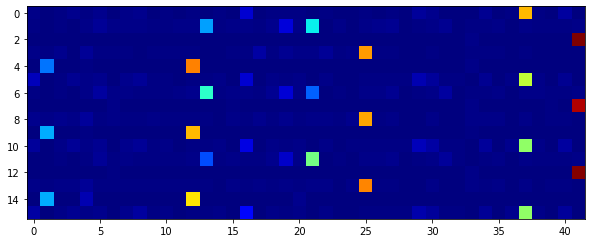

epochs: 11/300, train loss : 0.77677 train mse: 0.54304 train mae: 0.48728  validation loss: 0.66189 validation mse : 0.49080 validation mae: 0.53359
epochs: 12/300, train loss : 0.75476 train mse: 0.51275 train mae: 0.46553  validation loss: 0.64885 validation mse : 0.50542 validation mae: 0.54146
epochs: 13/300, train loss : 0.73407 train mse: 0.48571 train mae: 0.44489  validation loss: 0.63383 validation mse : 0.45355 validation mae: 0.50881
epochs: 14/300, train loss : 0.71436 train mse: 0.45821 train mae: 0.42360  validation loss: 0.61861 validation mse : 0.42082 validation mae: 0.48586
epochs: 15/300, train loss : 0.69572 train mse: 0.43466 train mae: 0.40403  validation loss: 0.60395 validation mse : 0.39859 validation mae: 0.46967
epochs: 16/300, train loss : 0.67807 train mse: 0.41339 train mae: 0.38558  validation loss: 0.59013 validation mse : 0.38297 validation mae: 0.45752
epochs: 17/300, train loss : 0.66137 train mse: 0.39407 train mae: 0.36803  validation loss: 0.57698

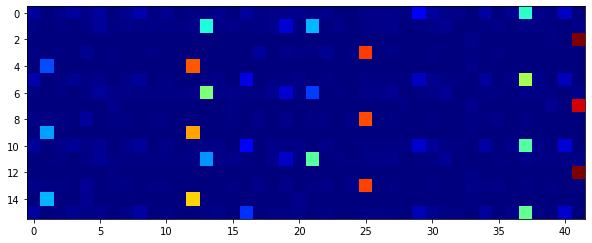

epochs: 21/300, train loss : 0.60295 train mse: 0.33437 train mae: 0.30788  validation loss: 0.53091 validation mse : 0.31814 validation mae: 0.40137
epochs: 22/300, train loss : 0.59022 train mse: 0.32300 train mae: 0.29480  validation loss: 0.52083 validation mse : 0.30924 validation mae: 0.39294
epochs: 23/300, train loss : 0.57816 train mse: 0.31285 train mae: 0.28280  validation loss: 0.51127 validation mse : 0.30097 validation mae: 0.38455
epochs: 24/300, train loss : 0.56673 train mse: 0.30376 train mae: 0.27162  validation loss: 0.50219 validation mse : 0.29327 validation mae: 0.37674
epochs: 25/300, train loss : 0.55590 train mse: 0.29590 train mae: 0.26113  validation loss: 0.49354 validation mse : 0.28601 validation mae: 0.36909
epochs: 26/300, train loss : 0.54561 train mse: 0.28845 train mae: 0.25144  validation loss: 0.48560 validation mse : 0.28699 validation mae: 0.36957
epochs: 27/300, train loss : 0.53584 train mse: 0.28184 train mae: 0.24239  validation loss: 0.47985

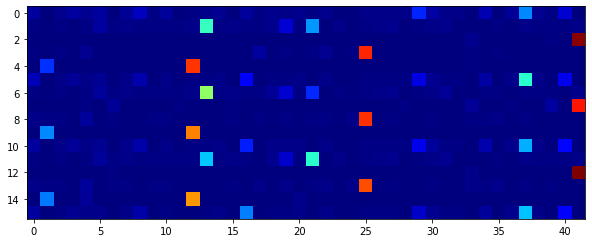

epochs: 31/300, train loss : 0.50139 train mse: 0.26218 train mae: 0.21283  validation loss: 0.45929 validation mse : 0.31522 validation mae: 0.37827
epochs: 32/300, train loss : 0.49381 train mse: 0.25879 train mae: 0.20711  validation loss: 0.45468 validation mse : 0.31182 validation mae: 0.37426
epochs: 33/300, train loss : 0.48659 train mse: 0.25567 train mae: 0.20200  validation loss: 0.45023 validation mse : 0.30777 validation mae: 0.36999
epochs: 34/300, train loss : 0.47973 train mse: 0.25336 train mae: 0.19727  validation loss: 0.44591 validation mse : 0.30345 validation mae: 0.36626
epochs: 35/300, train loss : 0.47322 train mse: 0.25183 train mae: 0.19553  validation loss: 0.44188 validation mse : 0.30482 validation mae: 0.36530
epochs: 36/300, train loss : 0.46700 train mse: 0.24933 train mae: 0.19073  validation loss: 0.43773 validation mse : 0.29238 validation mae: 0.36019
epochs: 37/300, train loss : 0.46106 train mse: 0.24703 train mae: 0.18610  validation loss: 0.43401

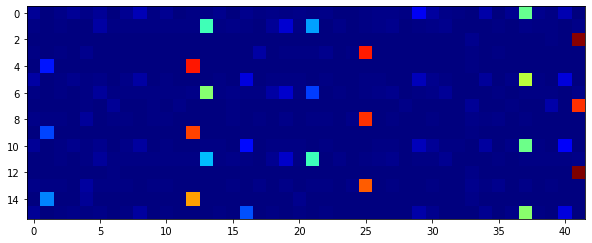

epochs: 41/300, train loss : 0.43971 train mse: 0.23962 train mae: 0.17115  validation loss: 0.42002 validation mse : 0.29500 validation mae: 0.35291
epochs: 42/300, train loss : 0.43491 train mse: 0.23827 train mae: 0.16973  validation loss: 0.41701 validation mse : 0.29341 validation mae: 0.35392
epochs: 43/300, train loss : 0.43032 train mse: 0.23741 train mae: 0.16816  validation loss: 0.41411 validation mse : 0.29238 validation mae: 0.35218
epochs: 44/300, train loss : 0.42592 train mse: 0.23661 train mae: 0.16678  validation loss: 0.41131 validation mse : 0.29107 validation mae: 0.35142
epochs: 45/300, train loss : 0.42170 train mse: 0.23610 train mae: 0.16607  validation loss: 0.40866 validation mse : 0.29191 validation mae: 0.35179
epochs: 46/300, train loss : 0.41764 train mse: 0.23519 train mae: 0.16316  validation loss: 0.40612 validation mse : 0.29175 validation mae: 0.35367
epochs: 47/300, train loss : 0.41374 train mse: 0.23417 train mae: 0.16166  validation loss: 0.40206

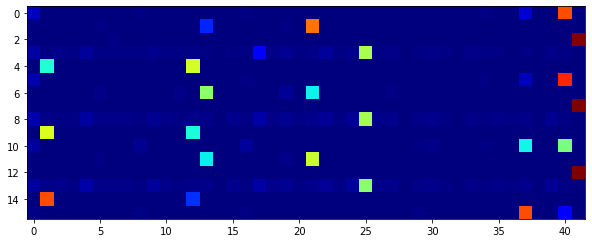

epochs: 51/300, train loss : 0.40087 train mse: 0.25520 train mae: 0.19152  validation loss: 0.38972 validation mse : 0.22759 validation mae: 0.31424
epochs: 52/300, train loss : 0.39790 train mse: 0.24642 train mae: 0.17634  validation loss: 0.38645 validation mse : 0.21955 validation mae: 0.29945
epochs: 53/300, train loss : 0.39504 train mse: 0.24615 train mae: 0.17049  validation loss: 0.38222 validation mse : 0.16221 validation mae: 0.24651
epochs: 54/300, train loss : 0.39216 train mse: 0.23931 train mae: 0.16081  validation loss: 0.37814 validation mse : 0.16218 validation mae: 0.24738
epochs: 55/300, train loss : 0.38934 train mse: 0.23720 train mae: 0.15608  validation loss: 0.37417 validation mse : 0.15953 validation mae: 0.24404
epochs: 56/300, train loss : 0.38660 train mse: 0.23608 train mae: 0.15458  validation loss: 0.37033 validation mse : 0.15950 validation mae: 0.24444
epochs: 57/300, train loss : 0.38395 train mse: 0.23523 train mae: 0.15237  validation loss: 0.36666

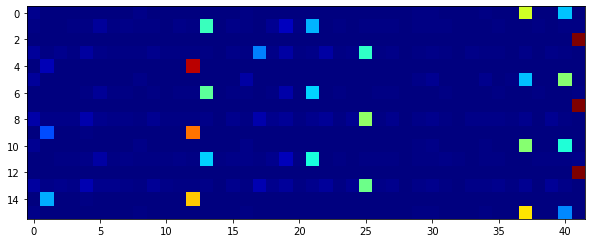

epochs: 61/300, train loss : 0.37409 train mse: 0.23297 train mae: 0.14750  validation loss: 0.35319 validation mse : 0.16079 validation mae: 0.24758
epochs: 62/300, train loss : 0.37181 train mse: 0.23272 train mae: 0.14757  validation loss: 0.35011 validation mse : 0.16187 validation mae: 0.24946
epochs: 63/300, train loss : 0.36960 train mse: 0.23263 train mae: 0.14871  validation loss: 0.34714 validation mse : 0.16310 validation mae: 0.25142
epochs: 64/300, train loss : 0.36746 train mse: 0.23223 train mae: 0.14829  validation loss: 0.34429 validation mse : 0.16501 validation mae: 0.25500
epochs: 65/300, train loss : 0.36537 train mse: 0.23203 train mae: 0.14830  validation loss: 0.34158 validation mse : 0.16773 validation mae: 0.25920
epochs: 66/300, train loss : 0.36335 train mse: 0.23159 train mae: 0.14786  validation loss: 0.33896 validation mse : 0.16884 validation mae: 0.26016
epochs: 67/300, train loss : 0.36137 train mse: 0.23134 train mae: 0.14756  validation loss: 0.33643

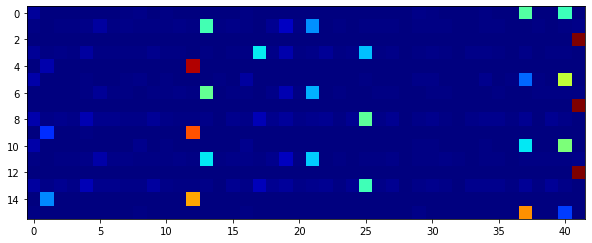

epochs: 71/300, train loss : 0.35402 train mse: 0.23060 train mae: 0.14791  validation loss: 0.32712 validation mse : 0.17184 validation mae: 0.26649
epochs: 72/300, train loss : 0.35230 train mse: 0.23052 train mae: 0.14774  validation loss: 0.32498 validation mse : 0.17306 validation mae: 0.26716
epochs: 73/300, train loss : 0.35063 train mse: 0.23051 train mae: 0.14896  validation loss: 0.32289 validation mse : 0.17284 validation mae: 0.26747
epochs: 74/300, train loss : 0.34901 train mse: 0.23071 train mae: 0.14933  validation loss: 0.32085 validation mse : 0.17180 validation mae: 0.26603
epochs: 75/300, train loss : 0.34743 train mse: 0.23007 train mae: 0.14853  validation loss: 0.31889 validation mse : 0.17338 validation mae: 0.26755
epochs: 76/300, train loss : 0.34588 train mse: 0.22986 train mae: 0.14861  validation loss: 0.31698 validation mse : 0.17377 validation mae: 0.26600
epochs: 77/300, train loss : 0.34437 train mse: 0.22965 train mae: 0.14831  validation loss: 0.31514

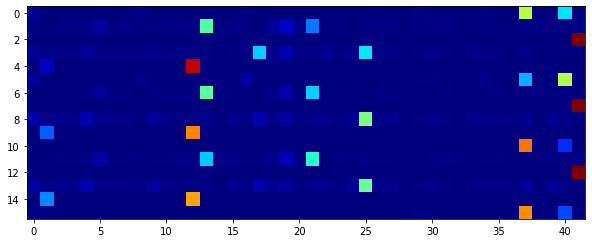

epochs: 81/300, train loss : 0.33868 train mse: 0.22895 train mae: 0.14769  validation loss: 0.30842 validation mse : 0.17959 validation mae: 0.27228
epochs: 82/300, train loss : 0.33734 train mse: 0.22887 train mae: 0.14906  validation loss: 0.30683 validation mse : 0.17843 validation mae: 0.26964
epochs: 83/300, train loss : 0.33603 train mse: 0.22883 train mae: 0.14862  validation loss: 0.30526 validation mse : 0.17632 validation mae: 0.26857
epochs: 84/300, train loss : 0.33476 train mse: 0.22910 train mae: 0.15084  validation loss: 0.30377 validation mse : 0.18033 validation mae: 0.27222
epochs: 85/300, train loss : 0.33351 train mse: 0.22912 train mae: 0.14863  validation loss: 0.30228 validation mse : 0.17697 validation mae: 0.26783
epochs: 86/300, train loss : 0.33230 train mse: 0.22879 train mae: 0.14927  validation loss: 0.30092 validation mse : 0.18526 validation mae: 0.27713
epochs: 87/300, train loss : 0.33111 train mse: 0.22903 train mae: 0.15028  validation loss: 0.29957

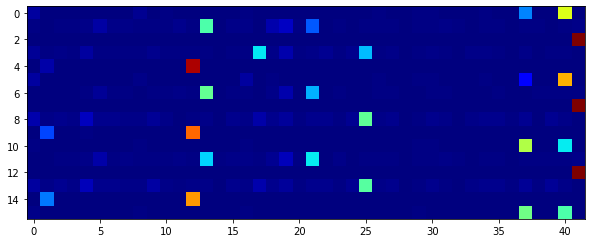

epochs: 91/300, train loss : 0.32659 train mse: 0.22800 train mae: 0.15192  validation loss: 0.29453 validation mse : 0.18441 validation mae: 0.27473
epochs: 92/300, train loss : 0.32553 train mse: 0.22852 train mae: 0.14904  validation loss: 0.29329 validation mse : 0.18001 validation mae: 0.26595
epochs: 93/300, train loss : 0.32448 train mse: 0.22781 train mae: 0.14982  validation loss: 0.29217 validation mse : 0.18951 validation mae: 0.27998
epochs: 94/300, train loss : 0.32345 train mse: 0.22779 train mae: 0.14975  validation loss: 0.29106 validation mse : 0.18740 validation mae: 0.27862
epochs: 95/300, train loss : 0.32245 train mse: 0.22893 train mae: 0.15049  validation loss: 0.28987 validation mse : 0.17853 validation mae: 0.27541
epochs: 96/300, train loss : 0.32148 train mse: 0.22925 train mae: 0.15186  validation loss: 0.28869 validation mse : 0.17610 validation mae: 0.27593
epochs: 97/300, train loss : 0.32053 train mse: 0.22904 train mae: 0.15303  validation loss: 0.28756

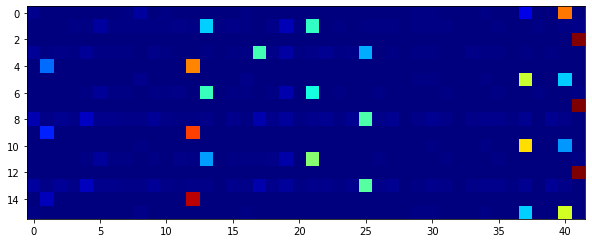

epochs: 101/300, train loss : 0.31691 train mse: 0.22845 train mae: 0.15063  validation loss: 0.28350 validation mse : 0.18642 validation mae: 0.27881
epochs: 102/300, train loss : 0.31604 train mse: 0.22872 train mae: 0.15063  validation loss: 0.28247 validation mse : 0.17913 validation mae: 0.27044
epochs: 103/300, train loss : 0.31519 train mse: 0.22798 train mae: 0.15141  validation loss: 0.28157 validation mse : 0.18975 validation mae: 0.28137
epochs: 104/300, train loss : 0.31435 train mse: 0.22765 train mae: 0.15040  validation loss: 0.28071 validation mse : 0.19124 validation mae: 0.28384
epochs: 105/300, train loss : 0.31352 train mse: 0.22727 train mae: 0.15038  validation loss: 0.27983 validation mse : 0.18867 validation mae: 0.27991
epochs: 106/300, train loss : 0.31270 train mse: 0.22714 train mae: 0.15147  validation loss: 0.27898 validation mse : 0.19010 validation mae: 0.28418
epochs: 107/300, train loss : 0.31190 train mse: 0.22704 train mae: 0.14996  validation loss: 

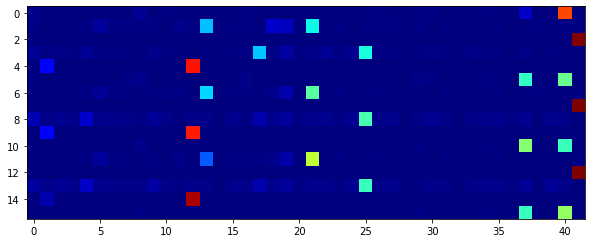

epochs: 111/300, train loss : 0.30884 train mse: 0.22712 train mae: 0.15113  validation loss: 0.27464 validation mse : 0.19054 validation mae: 0.28045
epochs: 112/300, train loss : 0.30810 train mse: 0.22629 train mae: 0.15231  validation loss: 0.27385 validation mse : 0.18671 validation mae: 0.28192
epochs: 113/300, train loss : 0.30738 train mse: 0.22620 train mae: 0.15271  validation loss: 0.27315 validation mse : 0.19423 validation mae: 0.28627
epochs: 114/300, train loss : 0.30667 train mse: 0.22607 train mae: 0.15295  validation loss: 0.27248 validation mse : 0.19675 validation mae: 0.28926
epochs: 115/300, train loss : 0.30596 train mse: 0.22597 train mae: 0.15155  validation loss: 0.27181 validation mse : 0.19533 validation mae: 0.28833
epochs: 116/300, train loss : 0.30527 train mse: 0.22565 train mae: 0.15001  validation loss: 0.27117 validation mse : 0.19773 validation mae: 0.29224
epochs: 117/300, train loss : 0.30459 train mse: 0.22518 train mae: 0.15361  validation loss: 

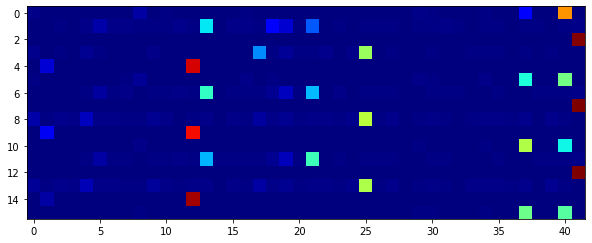

epochs: 121/300, train loss : 0.30197 train mse: 0.22507 train mae: 0.15366  validation loss: 0.26822 validation mse : 0.19978 validation mae: 0.29131
epochs: 122/300, train loss : 0.30134 train mse: 0.22493 train mae: 0.15145  validation loss: 0.26768 validation mse : 0.20227 validation mae: 0.29439
epochs: 123/300, train loss : 0.30072 train mse: 0.22486 train mae: 0.15328  validation loss: 0.26713 validation mse : 0.20015 validation mae: 0.29172
epochs: 124/300, train loss : 0.30011 train mse: 0.22509 train mae: 0.15265  validation loss: 0.26664 validation mse : 0.20570 validation mae: 0.29884
epochs: 125/300, train loss : 0.29950 train mse: 0.22453 train mae: 0.15453  validation loss: 0.26613 validation mse : 0.20279 validation mae: 0.29460
epochs: 126/300, train loss : 0.29914 train mse: 0.25368 train mae: 0.16878  validation loss: 0.26605 validation mse : 0.25662 validation mae: 0.34430
epochs: 127/300, train loss : 0.29915 train mse: 0.30052 train mae: 0.23078  validation loss: 

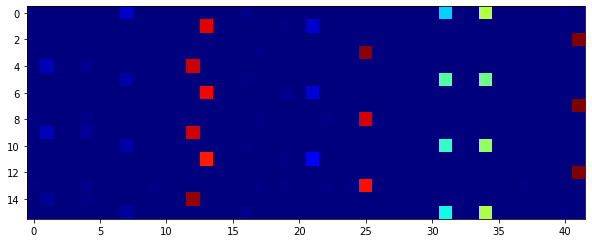

epochs: 131/300, train loss : 0.29755 train mse: 0.23736 train mae: 0.16212  validation loss: 0.26304 validation mse : 0.18799 validation mae: 0.28444
epochs: 132/300, train loss : 0.29707 train mse: 0.23445 train mae: 0.15708  validation loss: 0.26265 validation mse : 0.21166 validation mae: 0.30099
epochs: 133/300, train loss : 0.29659 train mse: 0.23315 train mae: 0.15377  validation loss: 0.26227 validation mse : 0.21249 validation mae: 0.30275
epochs: 134/300, train loss : 0.29610 train mse: 0.23184 train mae: 0.15276  validation loss: 0.26190 validation mse : 0.21273 validation mae: 0.30216
epochs: 135/300, train loss : 0.29562 train mse: 0.23136 train mae: 0.15113  validation loss: 0.26152 validation mse : 0.21100 validation mae: 0.29837
epochs: 136/300, train loss : 0.29515 train mse: 0.23085 train mae: 0.15120  validation loss: 0.26115 validation mse : 0.21142 validation mae: 0.29864
epochs: 137/300, train loss : 0.29468 train mse: 0.23062 train mae: 0.14947  validation loss: 

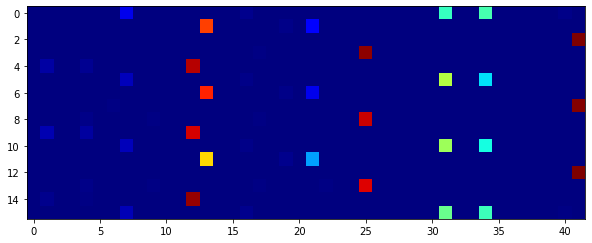

epochs: 141/300, train loss : 0.29283 train mse: 0.22915 train mae: 0.14842  validation loss: 0.25849 validation mse : 0.09879 validation mae: 0.22426
epochs: 142/300, train loss : 0.29238 train mse: 0.22869 train mae: 0.14793  validation loss: 0.25736 validation mse : 0.09833 validation mae: 0.22265
epochs: 143/300, train loss : 0.29193 train mse: 0.22852 train mae: 0.14806  validation loss: 0.25625 validation mse : 0.09872 validation mae: 0.22213
epochs: 144/300, train loss : 0.29149 train mse: 0.22860 train mae: 0.14790  validation loss: 0.25517 validation mse : 0.10024 validation mae: 0.22395
epochs: 145/300, train loss : 0.29106 train mse: 0.22881 train mae: 0.14970  validation loss: 0.25409 validation mse : 0.09835 validation mae: 0.22049
epochs: 146/300, train loss : 0.29063 train mse: 0.22899 train mae: 0.14641  validation loss: 0.25304 validation mse : 0.10049 validation mae: 0.22278
epochs: 147/300, train loss : 0.29021 train mse: 0.22815 train mae: 0.14893  validation loss: 

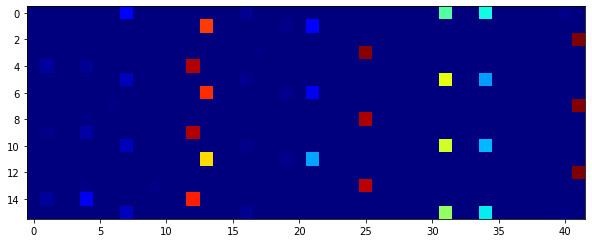

epochs: 151/300, train loss : 0.28855 train mse: 0.22736 train mae: 0.14812  validation loss: 0.24913 validation mse : 0.09649 validation mae: 0.22367
epochs: 152/300, train loss : 0.28815 train mse: 0.22720 train mae: 0.14548  validation loss: 0.24816 validation mse : 0.10118 validation mae: 0.22690
epochs: 153/300, train loss : 0.28775 train mse: 0.22690 train mae: 0.15016  validation loss: 0.24735 validation mse : 0.12440 validation mae: 0.24749
epochs: 154/300, train loss : 0.28736 train mse: 0.22797 train mae: 0.14639  validation loss: 0.24622 validation mse : 0.07349 validation mae: 0.20164
epochs: 155/300, train loss : 0.28697 train mse: 0.22691 train mae: 0.15011  validation loss: 0.24546 validation mse : 0.12782 validation mae: 0.25103
epochs: 156/300, train loss : 0.28659 train mse: 0.22727 train mae: 0.14552  validation loss: 0.24453 validation mse : 0.10141 validation mae: 0.22618
epochs: 157/300, train loss : 0.28620 train mse: 0.22640 train mae: 0.14819  validation loss: 

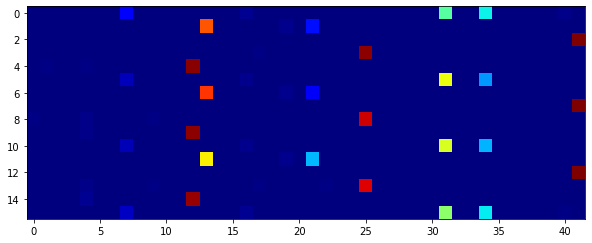

epochs: 161/300, train loss : 0.28471 train mse: 0.22572 train mae: 0.14771  validation loss: 0.24077 validation mse : 0.12865 validation mae: 0.25017
epochs: 162/300, train loss : 0.28434 train mse: 0.22607 train mae: 0.14949  validation loss: 0.24010 validation mse : 0.13171 validation mae: 0.25397
epochs: 163/300, train loss : 0.28398 train mse: 0.22572 train mae: 0.14697  validation loss: 0.23941 validation mse : 0.12859 validation mae: 0.24959
epochs: 164/300, train loss : 0.28363 train mse: 0.22526 train mae: 0.15005  validation loss: 0.23878 validation mse : 0.13549 validation mae: 0.25701
epochs: 165/300, train loss : 0.28327 train mse: 0.22527 train mae: 0.14724  validation loss: 0.23797 validation mse : 0.10545 validation mae: 0.22850
epochs: 166/300, train loss : 0.28292 train mse: 0.22510 train mae: 0.14977  validation loss: 0.23723 validation mse : 0.11526 validation mae: 0.24085
epochs: 167/300, train loss : 0.28258 train mse: 0.22509 train mae: 0.14878  validation loss: 

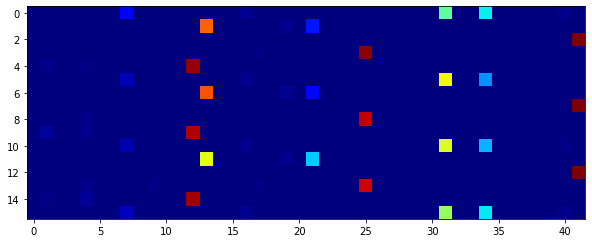

epochs: 171/300, train loss : 0.28123 train mse: 0.22425 train mae: 0.14634  validation loss: 0.23401 validation mse : 0.13845 validation mae: 0.25843
epochs: 172/300, train loss : 0.28090 train mse: 0.22444 train mae: 0.15238  validation loss: 0.23346 validation mse : 0.13890 validation mae: 0.26081
epochs: 173/300, train loss : 0.28057 train mse: 0.22513 train mae: 0.14700  validation loss: 0.23274 validation mse : 0.10931 validation mae: 0.23223
epochs: 174/300, train loss : 0.28025 train mse: 0.22440 train mae: 0.15371  validation loss: 0.23214 validation mse : 0.12823 validation mae: 0.25562
epochs: 175/300, train loss : 0.27993 train mse: 0.22473 train mae: 0.14595  validation loss: 0.23146 validation mse : 0.11221 validation mae: 0.23811
epochs: 176/300, train loss : 0.27962 train mse: 0.22453 train mae: 0.15189  validation loss: 0.23086 validation mse : 0.12558 validation mae: 0.25201
epochs: 177/300, train loss : 0.27931 train mse: 0.22420 train mae: 0.14658  validation loss: 

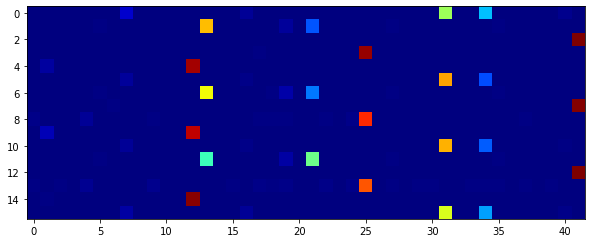

epochs: 181/300, train loss : 0.27813 train mse: 0.22721 train mae: 0.14931  validation loss: 0.22774 validation mse : 0.10020 validation mae: 0.23064
epochs: 182/300, train loss : 0.27786 train mse: 0.22859 train mae: 0.15495  validation loss: 0.22705 validation mse : 0.10272 validation mae: 0.23739
epochs: 183/300, train loss : 0.27783 train mse: 0.27380 train mae: 0.21679  validation loss: 0.22713 validation mse : 0.24206 validation mae: 0.32666
epochs: 184/300, train loss : 0.27781 train mse: 0.27437 train mae: 0.22214  validation loss: 0.22670 validation mse : 0.14855 validation mae: 0.24900
epochs: 185/300, train loss : 0.27766 train mse: 0.24963 train mae: 0.17715  validation loss: 0.22623 validation mse : 0.13974 validation mae: 0.23459
epochs: 186/300, train loss : 0.27749 train mse: 0.24481 train mae: 0.16546  validation loss: 0.22574 validation mse : 0.13423 validation mae: 0.22647
epochs: 187/300, train loss : 0.27729 train mse: 0.24138 train mae: 0.15790  validation loss: 

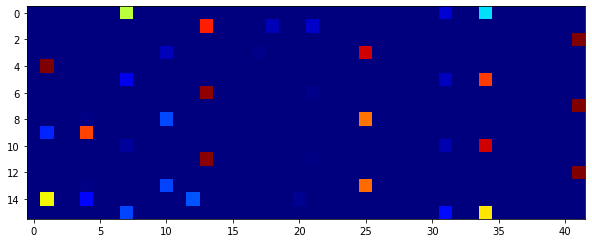

epochs: 191/300, train loss : 0.27644 train mse: 0.23535 train mae: 0.14882  validation loss: 0.22338 validation mse : 0.13596 validation mae: 0.22911
epochs: 192/300, train loss : 0.27622 train mse: 0.23460 train mae: 0.14749  validation loss: 0.22292 validation mse : 0.13583 validation mae: 0.22874
epochs: 193/300, train loss : 0.27600 train mse: 0.23420 train mae: 0.14708  validation loss: 0.22247 validation mse : 0.13627 validation mae: 0.22907
epochs: 194/300, train loss : 0.27579 train mse: 0.23366 train mae: 0.14670  validation loss: 0.22203 validation mse : 0.13601 validation mae: 0.22873
epochs: 195/300, train loss : 0.27557 train mse: 0.23330 train mae: 0.14655  validation loss: 0.22159 validation mse : 0.13765 validation mae: 0.23190
epochs: 196/300, train loss : 0.27535 train mse: 0.23288 train mae: 0.14587  validation loss: 0.22116 validation mse : 0.13733 validation mae: 0.23155
epochs: 197/300, train loss : 0.27513 train mse: 0.23256 train mae: 0.14623  validation loss: 

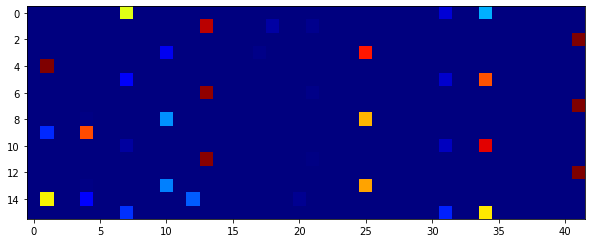

epochs: 201/300, train loss : 0.27425 train mse: 0.22975 train mae: 0.14347  validation loss: 0.21911 validation mse : 0.13902 validation mae: 0.23366
epochs: 202/300, train loss : 0.27403 train mse: 0.22956 train mae: 0.14306  validation loss: 0.21872 validation mse : 0.13941 validation mae: 0.23447
epochs: 203/300, train loss : 0.27381 train mse: 0.22942 train mae: 0.14319  validation loss: 0.21833 validation mse : 0.14006 validation mae: 0.23545
epochs: 204/300, train loss : 0.27359 train mse: 0.22934 train mae: 0.14303  validation loss: 0.21795 validation mse : 0.14076 validation mae: 0.23654
epochs: 205/300, train loss : 0.27337 train mse: 0.22924 train mae: 0.14285  validation loss: 0.21758 validation mse : 0.14126 validation mae: 0.23718
epochs: 206/300, train loss : 0.27316 train mse: 0.22906 train mae: 0.14287  validation loss: 0.21721 validation mse : 0.14159 validation mae: 0.23772
epochs: 207/300, train loss : 0.27295 train mse: 0.22893 train mae: 0.14291  validation loss: 

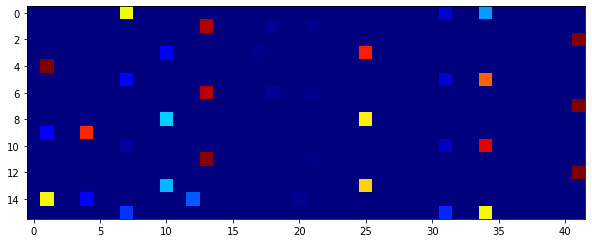

epochs: 211/300, train loss : 0.27211 train mse: 0.22869 train mae: 0.14299  validation loss: 0.21535 validation mse : 0.13822 validation mae: 0.23315
epochs: 212/300, train loss : 0.27190 train mse: 0.22881 train mae: 0.14320  validation loss: 0.21499 validation mse : 0.13853 validation mae: 0.23334
epochs: 213/300, train loss : 0.27170 train mse: 0.22872 train mae: 0.14272  validation loss: 0.21463 validation mse : 0.13880 validation mae: 0.23341
epochs: 214/300, train loss : 0.27150 train mse: 0.22856 train mae: 0.14312  validation loss: 0.21428 validation mse : 0.13879 validation mae: 0.23306
epochs: 215/300, train loss : 0.27130 train mse: 0.22844 train mae: 0.14262  validation loss: 0.21393 validation mse : 0.13809 validation mae: 0.23155
epochs: 216/300, train loss : 0.27110 train mse: 0.22824 train mae: 0.14283  validation loss: 0.21357 validation mse : 0.13781 validation mae: 0.23088
epochs: 217/300, train loss : 0.27090 train mse: 0.22806 train mae: 0.14285  validation loss: 

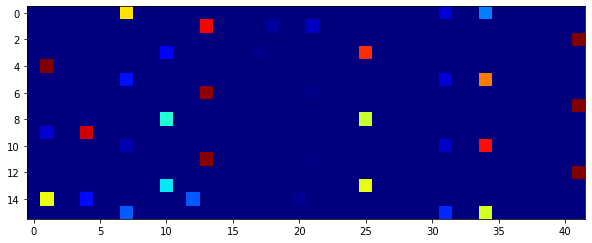

epochs: 221/300, train loss : 0.27012 train mse: 0.22754 train mae: 0.14311  validation loss: 0.21185 validation mse : 0.13740 validation mae: 0.23141
epochs: 222/300, train loss : 0.26993 train mse: 0.22756 train mae: 0.14293  validation loss: 0.21152 validation mse : 0.13694 validation mae: 0.23100
epochs: 223/300, train loss : 0.26974 train mse: 0.22736 train mae: 0.14301  validation loss: 0.21118 validation mse : 0.13681 validation mae: 0.23084
epochs: 224/300, train loss : 0.26955 train mse: 0.22732 train mae: 0.14301  validation loss: 0.21085 validation mse : 0.13708 validation mae: 0.23119
epochs: 225/300, train loss : 0.26936 train mse: 0.22716 train mae: 0.14300  validation loss: 0.21052 validation mse : 0.13755 validation mae: 0.23139
epochs: 226/300, train loss : 0.26917 train mse: 0.22711 train mae: 0.14317  validation loss: 0.21020 validation mse : 0.13798 validation mae: 0.23200
epochs: 227/300, train loss : 0.26899 train mse: 0.22695 train mae: 0.14301  validation loss: 

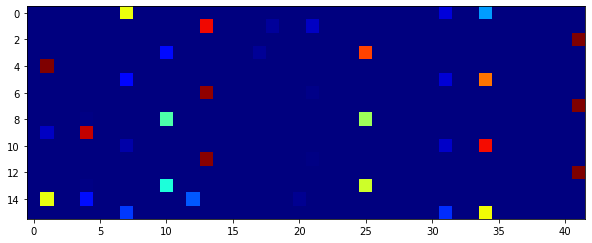

epochs: 231/300, train loss : 0.26826 train mse: 0.22677 train mae: 0.14311  validation loss: 0.20867 validation mse : 0.13937 validation mae: 0.23326
epochs: 232/300, train loss : 0.26808 train mse: 0.22655 train mae: 0.14363  validation loss: 0.20837 validation mse : 0.13916 validation mae: 0.23329
epochs: 233/300, train loss : 0.26790 train mse: 0.22647 train mae: 0.14300  validation loss: 0.20807 validation mse : 0.13899 validation mae: 0.23235
epochs: 234/300, train loss : 0.26772 train mse: 0.22654 train mae: 0.14359  validation loss: 0.20778 validation mse : 0.14128 validation mae: 0.23447
epochs: 235/300, train loss : 0.26755 train mse: 0.22633 train mae: 0.14309  validation loss: 0.20750 validation mse : 0.14183 validation mae: 0.23473
epochs: 236/300, train loss : 0.26737 train mse: 0.22612 train mae: 0.14384  validation loss: 0.20723 validation mse : 0.14316 validation mae: 0.23602
epochs: 237/300, train loss : 0.26720 train mse: 0.22602 train mae: 0.14309  validation loss: 

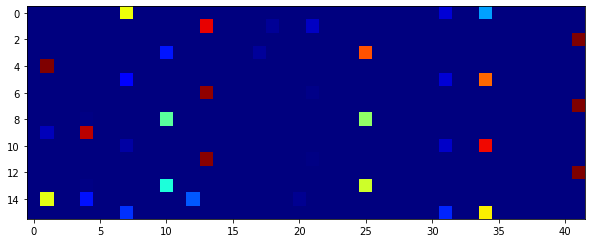

epochs: 241/300, train loss : 0.26651 train mse: 0.22577 train mae: 0.14329  validation loss: 0.20591 validation mse : 0.14297 validation mae: 0.23592
epochs: 242/300, train loss : 0.26634 train mse: 0.22575 train mae: 0.14470  validation loss: 0.20566 validation mse : 0.14459 validation mae: 0.23766
epochs: 243/300, train loss : 0.26617 train mse: 0.22554 train mae: 0.14348  validation loss: 0.20540 validation mse : 0.14281 validation mae: 0.23641
epochs: 244/300, train loss : 0.26601 train mse: 0.22548 train mae: 0.14439  validation loss: 0.20515 validation mse : 0.14493 validation mae: 0.23859
epochs: 245/300, train loss : 0.26584 train mse: 0.22527 train mae: 0.14330  validation loss: 0.20490 validation mse : 0.14422 validation mae: 0.23811
epochs: 246/300, train loss : 0.26568 train mse: 0.22525 train mae: 0.14449  validation loss: 0.20467 validation mse : 0.14669 validation mae: 0.24070
epochs: 247/300, train loss : 0.26551 train mse: 0.22506 train mae: 0.14378  validation loss: 

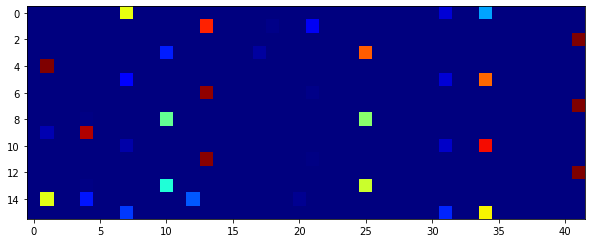

epochs: 251/300, train loss : 0.26486 train mse: 0.22467 train mae: 0.14319  validation loss: 0.20350 validation mse : 0.14557 validation mae: 0.23988
epochs: 252/300, train loss : 0.26470 train mse: 0.22464 train mae: 0.14452  validation loss: 0.20327 validation mse : 0.14522 validation mae: 0.23988
epochs: 253/300, train loss : 0.26454 train mse: 0.22467 train mae: 0.14308  validation loss: 0.20304 validation mse : 0.14487 validation mae: 0.23910
epochs: 254/300, train loss : 0.26439 train mse: 0.22477 train mae: 0.14519  validation loss: 0.20282 validation mse : 0.14779 validation mae: 0.24062
epochs: 255/300, train loss : 0.26423 train mse: 0.22453 train mae: 0.14252  validation loss: 0.20259 validation mse : 0.14534 validation mae: 0.23774
epochs: 256/300, train loss : 0.26408 train mse: 0.22439 train mae: 0.14433  validation loss: 0.20238 validation mse : 0.14777 validation mae: 0.24096
epochs: 257/300, train loss : 0.26392 train mse: 0.22420 train mae: 0.14337  validation loss: 

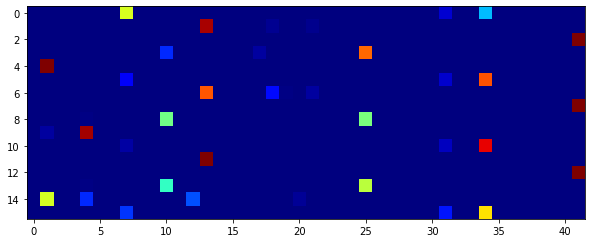

epochs: 261/300, train loss : 0.26331 train mse: 0.22415 train mae: 0.14355  validation loss: 0.20136 validation mse : 0.14710 validation mae: 0.24089
epochs: 262/300, train loss : 0.26316 train mse: 0.22390 train mae: 0.14406  validation loss: 0.20116 validation mse : 0.14819 validation mae: 0.24196
epochs: 263/300, train loss : 0.26301 train mse: 0.22399 train mae: 0.14448  validation loss: 0.20098 validation mse : 0.15251 validation mae: 0.24538
epochs: 264/300, train loss : 0.26287 train mse: 0.22378 train mae: 0.14343  validation loss: 0.20079 validation mse : 0.15204 validation mae: 0.24451
epochs: 265/300, train loss : 0.26272 train mse: 0.22376 train mae: 0.14483  validation loss: 0.20061 validation mse : 0.15360 validation mae: 0.24606
epochs: 266/300, train loss : 0.26257 train mse: 0.22359 train mae: 0.14361  validation loss: 0.20043 validation mse : 0.15214 validation mae: 0.24533
epochs: 267/300, train loss : 0.26242 train mse: 0.22356 train mae: 0.14459  validation loss: 

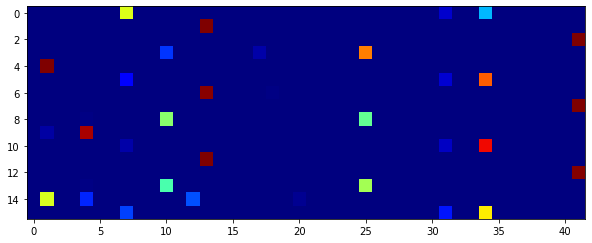

epochs: 271/300, train loss : 0.26185 train mse: 0.22312 train mae: 0.14442  validation loss: 0.19955 validation mse : 0.15378 validation mae: 0.24787
epochs: 272/300, train loss : 0.26171 train mse: 0.22362 train mae: 0.14477  validation loss: 0.19951 validation mse : 0.18863 validation mae: 0.27852
epochs: 273/300, train loss : 0.26157 train mse: 0.22337 train mae: 0.14530  validation loss: 0.19959 validation mse : 0.22112 validation mae: 0.29142
epochs: 274/300, train loss : 0.26143 train mse: 0.22304 train mae: 0.14366  validation loss: 0.19965 validation mse : 0.21830 validation mae: 0.28907
epochs: 275/300, train loss : 0.26128 train mse: 0.22277 train mae: 0.14451  validation loss: 0.19972 validation mse : 0.21814 validation mae: 0.28794
epochs: 276/300, train loss : 0.26114 train mse: 0.22270 train mae: 0.14394  validation loss: 0.19980 validation mse : 0.22053 validation mae: 0.29182
epochs: 277/300, train loss : 0.26101 train mse: 0.22260 train mae: 0.14433  validation loss: 

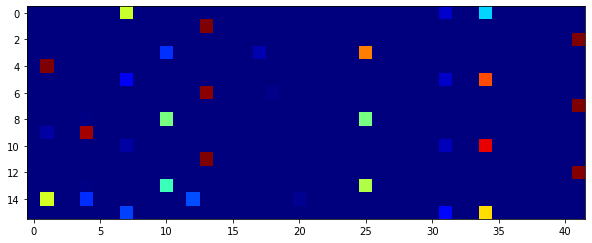

epochs: 281/300, train loss : 0.26046 train mse: 0.22224 train mae: 0.14422  validation loss: 0.20015 validation mse : 0.21880 validation mae: 0.28918
epochs: 282/300, train loss : 0.26032 train mse: 0.22188 train mae: 0.14473  validation loss: 0.20023 validation mse : 0.22169 validation mae: 0.29324
epochs: 283/300, train loss : 0.26018 train mse: 0.22182 train mae: 0.14440  validation loss: 0.20030 validation mse : 0.22133 validation mae: 0.29227
epochs: 284/300, train loss : 0.26005 train mse: 0.22162 train mae: 0.14466  validation loss: 0.20038 validation mse : 0.22257 validation mae: 0.29435
epochs: 285/300, train loss : 0.25991 train mse: 0.22163 train mae: 0.14453  validation loss: 0.20046 validation mse : 0.22300 validation mae: 0.29369
epochs: 286/300, train loss : 0.25978 train mse: 0.22140 train mae: 0.14459  validation loss: 0.20054 validation mse : 0.22342 validation mae: 0.29491
epochs: 287/300, train loss : 0.25965 train mse: 0.22152 train mae: 0.14512  validation loss: 

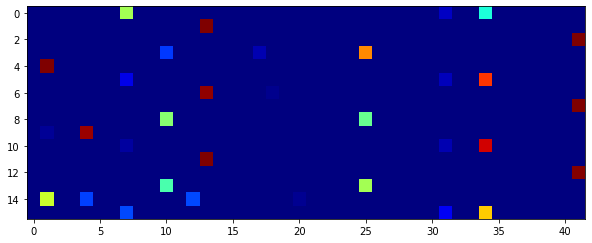

epochs: 291/300, train loss : 0.25912 train mse: 0.22125 train mae: 0.14511  validation loss: 0.20093 validation mse : 0.22332 validation mae: 0.29221
epochs: 292/300, train loss : 0.25899 train mse: 0.22118 train mae: 0.14408  validation loss: 0.20101 validation mse : 0.22487 validation mae: 0.29472
epochs: 293/300, train loss : 0.25886 train mse: 0.22106 train mae: 0.14573  validation loss: 0.20109 validation mse : 0.22509 validation mae: 0.29428
epochs: 294/300, train loss : 0.25873 train mse: 0.22090 train mae: 0.14356  validation loss: 0.20118 validation mse : 0.22640 validation mae: 0.29601
epochs: 295/300, train loss : 0.25860 train mse: 0.22095 train mae: 0.14630  validation loss: 0.20126 validation mse : 0.22550 validation mae: 0.29449
epochs: 296/300, train loss : 0.25848 train mse: 0.22077 train mae: 0.14338  validation loss: 0.20134 validation mse : 0.22636 validation mae: 0.29577
epochs: 297/300, train loss : 0.25835 train mse: 0.22055 train mae: 0.14538  validation loss: 

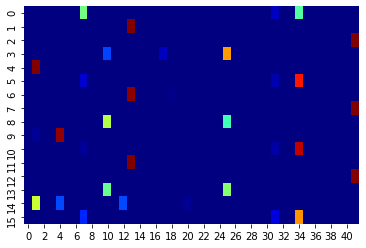

In [245]:
try :
    os.mkdir(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except:
    print("폴더가 이미 존재")

visual_list = []
for epoch in range(EPOCHS):
    epoch_train_mse = 0
    epoch_train_mae = 0
    
    epoch_val_mse = 0
    epoch_val_mae = 0

    train_data_len = 0
    val_data_len = 0

    for train_X, train_y in train_dataset:
        _, train_mse, train_mae, attention_weights = train_function(train_X, train_y)
        train_data_len += 1
        epoch_train_mse += tf.reduce_mean(train_mse).numpy()
        epoch_train_mae += tf.reduce_mean(train_mae).numpy()
    for test_images, test_labels in val_dataset:
        _, val_mse, val_mae = test_function(test_images, test_labels)
        val_data_len += 1
        epoch_val_mse += tf.reduce_mean(val_mse).numpy()
        epoch_val_mae += tf.reduce_mean(val_mae).numpy()

    train_loss_list.append(train_loss.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    visual_result = VisualizeAttentionMap(model, train_X, attention_weights).on_epoch_begin(epoch)
    visual_list.append(visual_result.numpy())
    template = 'epochs: {}/{}, train loss : {:.5f} train mse: {:.5f} train mae: {:.5f}  validation loss: {:.5f} validation mse : {:.5f} validation mae: {:.5f}'
    print(template.format(epoch+1,
                         EPOCHS,
                         train_loss.result().numpy(),
                         epoch_train_mse / train_data_len,
                         epoch_train_mae / train_data_len,
                         val_loss.result().numpy(),
                         epoch_val_mse / val_data_len,
                         epoch_val_mae / val_data_len))
  
    if (epoch+1) % 10 == 0 :
        model.save_weights(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/model_{epoch+1}.pth') 



try :
    os.mkdir(f'../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except:
    print("폴더가 이미 존재")

for idx, img in enumerate(visual_list) :
    tmp = sns.heatmap(img, cmap ='jet', cbar = False)
    tmp.figure.savefig(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/{idx}.png")
    
    
    
path = [f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/{i}" for i in os.listdir(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}") if i.endswith(".png")]
paths = [np.array(Image.open(i)) for i in path]

try :
    os.mkdir(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except :
    print("폴더가 이미 존재")
    
imageio.mimsave(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}.gif', paths, fps=5)

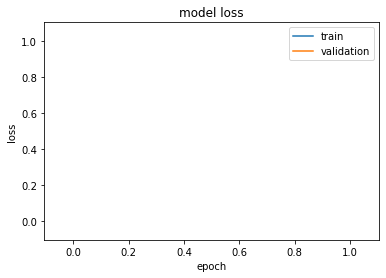

In [21]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [294]:
for i in range(10, 301 ,10) :
    model.load_weights(f"../data/model_weights/model_300_600_310_cluster_3/model_{i}.pth")
    X_test, y_test = preprocessor.transform(test_data.values)
    scores = np.mean(np.abs(y_test , model.predict(X_test)[0]))

    print(f"Model MAE : {scores}")

    # Predict
    y_pred,_ = model.predict(X_test)
    y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test = preprocessor.y_scaler.inverse_transform(y_test.reshape(-1, 1))
    comparison = np.hstack([y_pred, y_test]) #0.93 #0.74 batch = 16 epoch = 100
    print(np.mean(np.abs(y_test - y_pred)))

Model MAE : 0.6359313130378723
48694.5392863612
Model MAE : 0.6359313130378723
33044.53127766271
Model MAE : 0.6359313130378723
22674.405359280496
Model MAE : 0.6359313130378723
19111.439339816185
Model MAE : 0.6359313130378723
26587.62184438398
Model MAE : 0.6359313130378723
14830.779068583826
Model MAE : 0.6359313130378723
15717.321851373488
Model MAE : 0.6359313130378723
15514.410163387176
Model MAE : 0.6359313130378723
15393.264657888105
Model MAE : 0.6359313130378723
16463.865550182712
Model MAE : 0.6359313130378723
16363.11487377536
Model MAE : 0.6359313130378723
17981.08450194328
Model MAE : 0.6359313130378723
22460.94282856603
Model MAE : 0.6359313130378723
23129.766638921923
Model MAE : 0.6359313130378723
24981.0989793839
Model MAE : 0.6359313130378723
24749.46971238659
Model MAE : 0.6359313130378723
24057.673996143956
Model MAE : 0.6359313130378723
24698.4831046812
Model MAE : 0.6359313130378723
15496.845419606854
Model MAE : 0.6359313130378723
16402.82981289279
Model MAE : 0

In [43]:
X_test, y_test = preprocessor.transform(test_data.values)
model.load_weights(f"../data/model_weights/model_300_600_310_cluster_3/model_60.pth")
y_pred,_ = model.predict(X_test)
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = preprocessor.y_scaler.inverse_transform(y_test.reshape(-1, 1))
comparison = np.hstack([y_pred, y_test])
print(np.mean(np.abs(y_test - y_pred)))

14830.779068583826


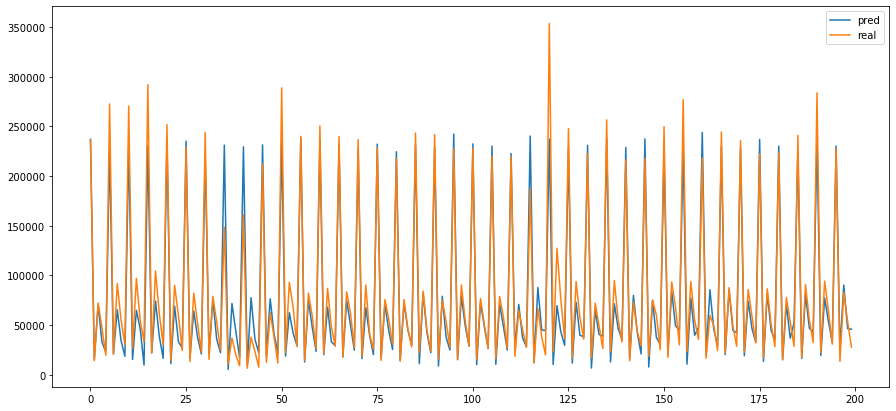

In [296]:
plt.figure(figsize=(15,7))
plt.plot(comparison[:200])
plt.legend(['pred','real'])
plt.show()

In [22]:
data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')
final_test_data = data[-look_back_window:]

In [23]:
final_dong_list = final_test_data.읍면동.unique()
final_test_data.drop(columns = '읍면동', inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [24]:
final_test_data = final_test_data.set_index(['일자'])

In [25]:
a = scaler.transform(final_test_data)

In [26]:
np.asarray([a]).shape

(1, 600, 42)

In [42]:
y_pred,_ = model.predict(np.asarray([a]))

In [41]:
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [32]:
i = list(final_dong_list)
i.pop(2)
final_dong_list = i

In [33]:
final_dong_cluster_3 = list(final_dong_list) * int(y_pred.shape[0] / len(final_dong_list))

In [36]:
final_result = pd.DataFrame(np.vstack([final_dong_cluster_3,np.reshape(y_pred, (y_pred.shape[0]))]).T, columns=['읍면동','7_8월예측값'])

In [307]:
final_result.to_csv(f'../data/processed_data/cluster_{cluster_num}_final_result.csv', encoding = 'cp949', index = False)